In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
!pip install pytorch-ignite

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
train_dataset = torchvision.datasets.SVHN('./data', 
                              transform=torchvision.transforms.ToTensor(), 
                              download=True)

Using downloaded and verified file: ./data/train_32x32.mat


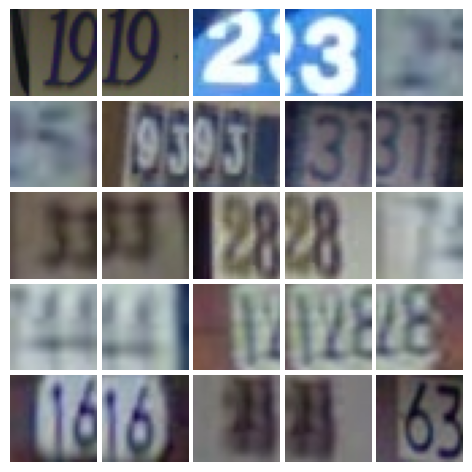

In [4]:
n = 5

fig = plt.figure(figsize=(6,6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n, n),
                 axes_pad=0.05)

for i, ax in enumerate(grid):
    img = train_dataset[i][0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

In [5]:
train_dataset.labels

array([1, 9, 2, ..., 1, 6, 9])

In [6]:
train_dataset.data.shape

(73257, 3, 32, 32)

In [7]:
#Atividades
#(2.0 pontos) Altere a arquitetura apresentada na Prática 2 para gerar imagens a partir do conjunto SVHN.

import gc
gc.collect()
torch.cuda.empty_cache()

In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import imageio
import numpy as np
import tqdm
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
from mpl_toolkits.axes_grid1 import ImageGrid

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims
        self.net = nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 3*32*32),            
            nn.Tanh(),
        )
    def forward(self, x):
        return self.net(x).view(-1, 3, 32, 32)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 3*32*32
        
        self.net = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.net(x)
    
    
class VanillaGAN:
    def __init__(self, latent_dims, criterion):
        self.latent_dims = latent_dims
        self.generator = Generator(latent_dims)
        self.discriminator = Discriminator()
        
        self.criterion = criterion
            
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=3e-4)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=3e-4)
    

    def to(self, device):
        self.generator.to(device)
        self.discriminator.to(device)

    def train_discriminator(self, real_data, fake_data):
        batch_size = real_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)
        fake_label = torch.zeros(batch_size, 1).to(device) # fake labels (0s)

        self.optimizer_d.zero_grad()

        output_real = self.discriminator(real_data)
        loss_real = criterion(output_real, real_label)

        output_fake = self.discriminator(fake_data)
        loss_fake = criterion(output_fake, fake_label)

        loss_real.backward()
        loss_fake.backward()
        self.optimizer_d.step()

        return (loss_real + loss_fake) * 0.5


    def train_generator(self, fake_data):
        batch_size = fake_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)

        self.optimizer_g.zero_grad()

        output = self.discriminator(fake_data)
        loss = self.criterion(output, real_label)

        loss.backward()
        self.optimizer_g.step()

        return loss
    
# function to create the noise vector
def create_noise(sample_size, latent_dims):
    return torch.randn(sample_size, latent_dims).to(device)

import numpy as np
from scipy.spatial import distance

def jensen_shannon_divergence(p, q):
        """
        Calculates the symmetric Jensen–Shannon divergence between the two PDFs
        """
        m = (p + q) * 0.5
        return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

    
def kl_divergence(p, q):
        """
        The Kullback–Leibler divergence.
        Defined only if q != 0 whenever p != 0.
        """
        assert np.all(np.isfinite(p))
        assert np.all(np.isfinite(q))
        assert not np.any(np.logical_and(p != 0, q == 0))
        p_pos = (p > 0)
        return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))


def train(model, train_loader, epochs=20):
    log_dict = {"train_generator_loss": [],                
                "train_discriminator_loss": [],   
                "jensen_shannon_divergence" : [],              
                "reconstructed_images":[]}
    
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        loss_g = 0.0
        loss_d = 0.0
        model.discriminator.train()
        model.generator.train()
        for data in tqdm.tqdm_notebook(train_loader):
            image, _ = data            
            image = image.to(device)
            batch_size = len(image)
            
            # train the discriminator network
            random_noise = create_noise(batch_size, model.latent_dims)            
            fake_data = model.generator(random_noise).detach() # detach() prevents from training generator
           
            real_data = image            
            loss_d += model.train_discriminator(real_data, fake_data)
            
            # train the generator network
            random_noise = create_noise(batch_size, model.latent_dims)
            fake_data = model.generator(random_noise)
            loss_g += model.train_generator(fake_data)

        log_dict["train_generator_loss"].append(loss_g.item()/len(train_loader))
        log_dict["train_discriminator_loss"].append(loss_d.item()/len(train_loader)) 
        p = np.resize(image.to('cpu').detach()[:5], (3*32*32))
        q = np.resize(fake_data.to('cpu').detach()[:5], (3*32*32))
        jensen_shannon =jensen_shannon_divergence(p,q) 
        log_dict["jensen_shannon_divergence"].append(jensen_shannon)      
            
        log_dict["reconstructed_images"].append(fake_data.to('cpu').detach()[:5])
    log_dict["original_images"] = image.to('cpu').detach()[:5]
    
    return model, log_dict

criterion = nn.BCELoss()
latent_dims = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
model = VanillaGAN(latent_dims, criterion)
model.to(device)
model, log_dict = train(model, train_loader, epochs=100)

    
    

/tmp/ipykernel_4071/452295728.py:141: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_4071/452295728.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm.tqdm_notebook(train_loader):


  0%|          | 0/573 [00:00<?, ?it/s]

/tmp/ipykernel_4071/452295728.py:132: RuntimeWarning: invalid value encountered in log
  return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))


  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/573 [00:00<?, ?it/s]

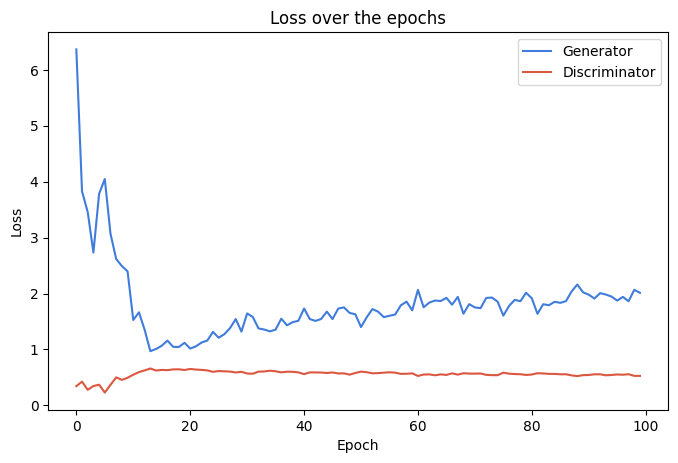

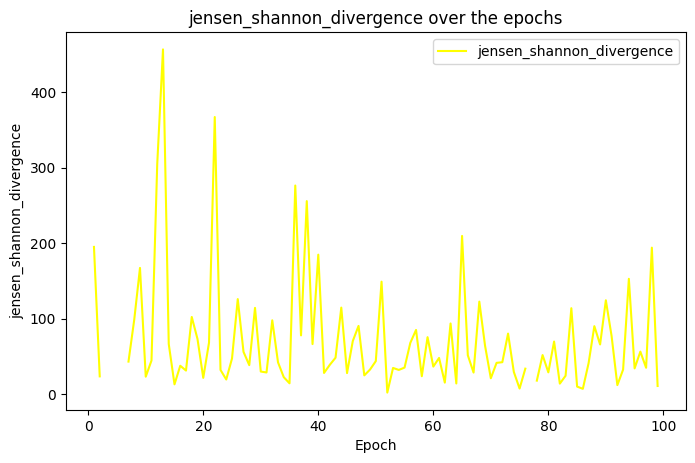

In [25]:
#Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;
from scipy.spatial import distance
# Auxiliar function to plot loss over the epochs
def plot_loss(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(history['train_generator_loss'], color='#407cdb', label='Generator')
    ax.plot(history['train_discriminator_loss'],color='#db5740', label='Discriminator')
   
    #distance.jensenshannon(a, b, axis=0)
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over the epochs')
    plt.show()
    
def plot_jensen_shannon_divergence(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(history['jensen_shannon_divergence'],color='yellow', label='jensen_shannon_divergence')
    #distance.jensenshannon(a, b, axis=0)
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('jensen_shannon_divergence')
    plt.title('jensen_shannon_divergence over the epochs')
    plt.show()    

plot_loss(log_dict)
plot_jensen_shannon_divergence(log_dict)

In [ ]:
reconstructed_images = log_dict["reconstructed_images"]
original_images = log_dict["original_images"]
dd =jensen_shannon_divergence(p,q) 
print(dd)

In [26]:
#Ao final do treino, avalie a qualidade dos exemplos gerados usando a métrica Fréchet Inception Distance (FID);

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
modelI = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

#reconstructed_images = log_dict["reconstructed_images"]
original_images = log_dict["original_images"]
random_noise = create_noise(100, model.latent_dims)            
fake_data = model.generator(random_noise).detach() # detach() prevents from training generator
images1 = original_images
images2 = fake_data.to('cpu').detach()
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(modelI, images1, images2)
print('FID: %.3f' % fid)



2022-10-22 22:58:30.044192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:58:30.048418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:58:30.048644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:58:30.048996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Scaled (5, 299, 299, 3) (100, 299, 299, 3)


2022-10-22 22:58:33.317207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


4/4 [==============================] - 1s 137ms/step
FID: 0.016


In [ ]:
import torchvision.utils as vutils
#Plote um grid com alguns exemplos gerados.
reconstructed_images = log_dict["reconstructed_images"]
original_images = log_dict["original_images"]
def plot_reconstructed(log_dict, step=5):
    
    plt.title('over the epochs')
    epochs = len(reconstructed_images)
    
    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(5, epochs//step + 1),
                    axes_pad=0.05)
    grid = iter(grid)
    for i in range(5):
        img = original_images[i].permute(1, 2, 0).numpy()
           
        #img = img.numpy().reshape((3,32,32))
        ax = next(grid)
        ax.imshow(img)
        ax.set_axis_off() 

        for j in range(epochs//step):
            img = reconstructed_images[j*step][i]            
            img = img.permute(1, 2, 0).numpy()
            ax = next(grid)
            ax.imshow((img * 255).astype(np.uint8))
            ax.set_axis_off()    

    plt.show()
    
    
def plot_new_Images():
    plt.figure()
    random_noise = create_noise(30, model.latent_dims)            
    fake_data = model.generator(random_noise).detach() # detach() prevents from training generator
    plt.imshow(np.transpose(vutils.make_grid(fake_data, padding=10, normalize=True).cpu(),(1,2,0)))    
    plt.title("new images")
    
def plot_newImageVsrealImages():
    plt.figure()
    %matplotlib inline
    reconstructed_images = log_dict["reconstructed_images"]
    original_images = log_dict["original_images"]
    # Grab a batch of real images from the dataloader
    real_batch = original_images

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[:32], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(reconstructed_images[-1], padding=2, normalize=True).cpu(),(1,2,0)))


plot_reconstructed(log_dict)
plot_new_Images()
plot_newImageVsrealImages()

In [ ]:
#Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

In [ ]:
#(4.0 pontos) Com base na arquitetura implementada na questão 1, construa uma GAN condicional para gerar imagens condicionadas aos rótulos.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST,SVHN
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#from tensorboardX import SummaryWriter

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(inputSize+10, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        #print(labels.shape)
        x = x.view(x.size(0), inputSize)
        #print(x.shape)
        c = self.label_emb(labels)
        #print(c.shape)
        x = torch.cat([x, c], 1)
        #print(x.shape)
        out = self.model(x)
        #print(out.shape)
        return out.squeeze()


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, inputSize),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 3, 32, 32)





class ConditionalGan:
    def __init__(self, latent_dims, criterion):
        self.latent_dims = latent_dims
        self.generator = Generator()
        self.discriminator = Discriminator()
        
        self.criterion = criterion
            
        #self.optimizer_g = optim.Adam(self.generator.parameters(), lr=3e-4)
        #self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=3e-4)
    

    def to(self, device):
        self.generator.to(device)
        self.discriminator.to(device)

    def train_discriminator(self, real_data, fake_data):
        batch_size = real_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)
        fake_label = torch.zeros(batch_size, 1).to(device) # fake labels (0s)

        self.optimizer_d.zero_grad()

        output_real = self.discriminator(real_data)
        loss_real = criterion(output_real, real_label)

        output_fake = self.discriminator(fake_data)
        loss_fake = criterion(output_fake, fake_label)

        loss_real.backward()
        loss_fake.backward()
        self.optimizer_d.step()

        return (loss_real + loss_fake) * 0.5


    def train_generator(self, fake_data):
        batch_size = fake_data.size(0)
        real_label = torch.ones(batch_size, 1).to(device) # real labels (1s)

        self.optimizer_g.zero_grad()

        output = self.discriminator(fake_data)
        loss = self.criterion(output, real_label)

        loss.backward()
        self.optimizer_g.step()

        return loss


    def generator_train_step(self,batch_size, discriminator, generator, g_optimizer, criterion):
        g_optimizer.zero_grad()
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_images = generator(z, fake_labels)
        validity = discriminator(fake_images, fake_labels)
        g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
        g_loss.backward()
        g_optimizer.step()
        return g_loss.item()
    def discriminator_train_step(self,batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
        d_optimizer.zero_grad()

        # train with real images
        real_validity = discriminator(real_images, labels)
        real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
        
        # train with fake images
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_images = generator(z, fake_labels)
        fake_validity = discriminator(fake_images, fake_labels)
        fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        return d_loss.item()

#writer = SummaryWriter()

    

log_dict_c = {"train_generator_loss": [],                
                "train_discriminator_loss": [],   
                "jensen_shannon_divergence" : [],              
                "reconstructed_images":[]}

def train():
  for epoch in range(num_epochs):
      print('Starting epoch {}...'.format(epoch), end=' ')
      for i, (images, labels) in enumerate(data_loader):
          
          step = epoch * len(data_loader) + i + 1
          real_images = Variable(images).cuda()
          labels = Variable(labels).cuda()
          modelcG.generator.train()
          
          d_loss = 0
          for _ in range(n_critic):
              d_loss = modelcG.discriminator_train_step(len(real_images), modelcG.discriminator,
                                                modelcG.generator, d_optimizer, criterion,
                                                real_images, labels)
          

          loss_g = modelcG.generator_train_step(batch_size, modelcG.discriminator, modelcG.generator, g_optimizer, criterion)
          
          #writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)  
          

          

          #log_dict["train_discriminator_loss"].append(loss_d.item()/len(train_loader))  
          
          if step % display_step == 0:
              modelcG.generator.eval()
              z = Variable(torch.randn(9, 100)).cuda()
              labels = Variable(torch.LongTensor(np.arange(9))).cuda()
              sample_images = modelcG.generator(z, labels).unsqueeze(1)
                
              #grid = make_grid(sample_images, nrow=3, normalize=True)
              #writer.add_image('sample_image', grid, step)
          log_dict_c["reconstructed_images"].append(real_images.to('cpu').detach()[:5])
                
      log_dict_c["train_generator_loss"].append(loss_g)
      log_dict_c["train_discriminator_loss"].append(d_loss/n_critic) 
      log_dict_c["original_images"] = real_images.to('cpu').detach()[:5]
        
      print('Done!')


batch_size = 32
data_loader = torch.utils.data.DataLoader(SVHN('data', download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)
#batch_size = 32
#data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
#                                          batch_size=batch_size, shuffle=True)
inputSize=3*32*32

num_epochs = 100
n_critic = 5
display_step = 50
criterion = nn.BCELoss()
latent_dims = 128
#generator = Generator().cuda()
#discriminator = Discriminator().cuda()
criterion = nn.BCELoss()

modelcG = ConditionalGan(latent_dims, criterion)
d_optimizer = torch.optim.Adam(modelcG.discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(modelcG.generator.parameters(), lr=1e-4)

modelcG.to(device) 
train()  

In [ ]:
#Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

##Ao final do treino, avalie os exemplos gerados usando a métrica Fréchet Inception Distance (FID);

##Plote um grid com alguns exemplos gerados e seus respectivos rótulos.

##Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

plot_loss(log_dict_c)
plot_jensen_shannon_divergence(log_dict_c)

In [ ]:
#3. (4.0 pontos) Modifique a arquitetura implementada na questão 2 **adicionando camadas convolucionais**.

#* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

#* Ao final do treino, avalie os exemplos gerados usando a métrica Fréchet Inception Distance (FID);

#* Plote um grid com alguns exemplos gerados e seus respectivos rótulos.

#Houve alguma melhoria em relação à arquitetura da questão 2? Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).


class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims
        self.net = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(self.latent_dims, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Block 2: input is 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Block 3: input is 256 x 8 x 8            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Block 4: input is 128 x 16 x 16
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),            
            nn.Tanh()
            # Output: output is (1) x 32 x 32
        )
    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 32*32
        
        self.net =  nn.Sequential(
            # Block 1: input is (1) x 32 x 32            
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (32) x 16 x 16
            nn.Conv2d(32, 32 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (32*2) x 8 x 8
            nn.Conv2d(32 * 2, 32 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (32*4) x 4 x 4
            nn.Conv2d(32 * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),            
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, x):        
        return self.net(x)    
    